In [ ]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from os import PathLike
from pathlib import Path
import re

from aind_vr_foraging_analysis.utils import parse, plotting_utils as plotting, AddExtraColumns
from aind_vr_foraging_analysis.utils import breathing_signal as breathing

# Plotting libraries
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = 'Z:/scratch/vr-foraging/data/'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\results'

In [24]:
class MetricsVrForaging():
    def __init__(self, session_path: PathLike):
        self.session_path = Path(session_path)
        self.data = parse.load_session_data(self.session_path)
        self.session = self.data['config'].streams.session_input.data['date'][:10]
        self.mouse = int(self.data['config'].streams.session_input.data['subject'])
        self.stage = self.data['config'].streams.tasklogic_input.data['stage_name']
        self.rig_name = self.data['config'].streams.rig_input.data['rig_name']

        print(self.rig_name)
        print(self.stage)
        if self.stage == 'thermistor screening':
            return
        
        self.data = parse.load_session_data(self.session_path)
        self.stage = self.data['config'].streams.tasklogic_input.data['stage_name']
        self.stream_data = parse.ContinuousData(self.data)
        self.total_epochs = parse.parse_dataframe(self.data)
        self.active_site = AddExtraColumns(self.total_epochs, run_on_init=True).total_epochs
        self.reward_sites = self.active_site.loc[self.active_site['label'] == 'OdorSite']
        self.reward_sites['odor_sites'] = np.arange(1, len(self.reward_sites)+1)
        self.df = self.retrieve_metrics()

    def retrieve_metrics(self) -> pd.DataFrame:
        reward_sites = self.reward_sites
        active_site = self.active_site
        data = self.data

        df = pd.DataFrame()
        # Summary of different relevants aspects -------------------------------------------------

        unrewarded_stops = reward_sites.loc[reward_sites.is_reward==0]['reward_amount'].count()
        rewarded_stops = reward_sites.loc[reward_sites.is_reward==1]['reward_amount'].count()
        water_collected = reward_sites.loc[(reward_sites['is_reward']==1)]['reward_amount'].sum()
        total_stops = reward_sites.loc[(reward_sites['is_choice']==True)]['reward_amount'].count()

        print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

        print('Total travelled m: ', np.round(active_site.start_position.max()/100,2), ', current position (cm): ', data['operation_control'].streams.CurrentPosition.data.max()[0]
        )

        for odor_label in reward_sites.odor_label.unique():
            values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['is_reward']==1)]['reward_amount'].sum()
            print(f'{odor_label} {values} ul')
            
        df.at[0,'odor_sites_travelled'] = int(len(reward_sites))
        df.at[0,'distance_m'] = data['operation_control'].streams.CurrentPosition.data.max()[0]/100
        df.at[0,'water_collected_ul'] = water_collected
        df.at[0,'rewarded_stops'] = int(rewarded_stops)
        df.at[0,'total_stops'] = int(total_stops)
        # df.at[0,'session_duration_min'] = (reward_sites.index[-1] - reward_sites.index[0])/60
        df.at[0, 'total_patches_visited'] = reward_sites.loc[reward_sites['site_number'] >= 1].patch_number.nunique()
        return df

    def retrieve_updater_values(self):
        # Initialize a pointer for the data values
        data_pointer = 0
        
        reward_sites = self.reward_sites
        data = self.data
        df = self.df
        
        # Save the updater values
        stop_duration = data['updater_events'].streams.UpdaterStopDurationOffset.data['data']
        stop_duration.reset_index(drop=True, inplace=True)
        delay = data['updater_events'].streams.UpdaterRewardDelayOffset.data['data']
        delay.reset_index(drop=True, inplace=True)
        velocity_threshold = data['updater_events'].streams.UpdaterStopVelocityThreshold.data['data']
        velocity_threshold.reset_index(drop=True, inplace=True)
        
        # Create a new column in reward_sites to store the updated values
        reward_sites['delay_s'] = None
        reward_sites['velocity_threshold_cms'] = None
        reward_sites['stop_duration_s'] = None

        try:
            # Iterate through each row of reward_sites
            for index, row in reward_sites.iterrows():
                if row['is_reward'] == 1:
                    # Copy the next available value from data and move the pointer
                    reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
                    data_pointer += 1
                else:
                    # Copy the same value without moving the pointer
                    reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
        except KeyError:
                reward_sites.at[index, 'delay_s'] = max(delay)
                reward_sites.at[index, 'velocity_threshold_cms'] = max(velocity_threshold)
                reward_sites.at[index, 'stop_duration_s'] = max(stop_duration)

        # Summary of the training metrics
        reward_sites['odor_sites'] = np.arange(1, len(reward_sites)+1)
        df.at[0,'start_delay'] = reward_sites['delay_s'].min()
        df.at[0,'end_delay'] = reward_sites['delay_s'].max()
        df.at[0, 'sites_to_max_delay'] = reward_sites[reward_sites['delay_s'] == reward_sites['delay_s'].max()].iloc[0]['odor_sites']
        df.at[0,'start_stop_duration'] = reward_sites['stop_duration_s'].min()
        df.at[0,'end_stop_duration'] = reward_sites['stop_duration_s'].max()
        df.at[0, 'sites_to_max_stop_duration'] = reward_sites[reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()].iloc[0]['odor_sites']
        df.at[0, 'rewarded_sites_in_max_stop'] = int(reward_sites[(reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max())&(reward_sites.is_choice == 1)]['odor_sites'].nunique())

        df.at[0,'start_velocity_threshold'] = reward_sites['velocity_threshold_cms'].min()
        df.at[0,'end_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
        df.at[0,'target_max_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
        df.at[0, 'sites_to_min_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].min()].iloc[0]['odor_sites']
            
        self.reward_sites = reward_sites
        self.df = df

    def get_metrics(self):
        return self.df

    def get_reward_sites(self):
        return self.reward_sites
    
    def get_mouse_and_session(self):
        return self.mouse, self.session
    
    def run_pdf_summary(self):
        color1='#d95f02'
        color2='#1b9e77'
        color3='#7570b3'
        color4='#e7298a'

        color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color1, 'Amyl Acetate': color3, 'Eugenol' : color3,
                            '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4, 'Methyl Butyrate': color2,}
        
        self.stream_data = parse.ContinuousData(self.data)
        encoder_data = self.stream_data.encoder_data
        odor_sites = AddExtraColumns(self.reward_sites, self.active_site, run_on_init=True).reward_sites
        active_site = AddExtraColumns(odor_sites, self.active_site).add_time_previous_intersite_interpatch()
        active_site['duration_epoch'] = active_site.index.to_series().diff().shift(-1)
        active_site['mouse'] = self.mouse
        active_site['session'] = self.session
        
        # Remove segments where the mouse was disengaged
        last_engaged_patch = odor_sites['patch_number'][odor_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = odor_sites['patch_number'].max()
            
        odor_sites['engaged'] = odor_sites['patch_number'] <= last_engaged_patch  
        
        # Recover color palette
        dict_odor = {}
        list_patches = parse.TaskSchemaProperties(self.data).patches
        for i, patches in enumerate(list_patches):
            # color_dict_label[patches['label']] = odor_list_color[i]
            dict_odor[i] = patches['label']
        
        trial_summary = plotting.trial_collection(odor_sites[['is_choice', 'site_number', 'odor_label', 'odor_sites', 'is_reward','depleted',
                                                                'reward_probability','reward_amount','reward_available']], 
                                                  encoder_data, 
                                                  self.mouse, 
                                                  self.session, 
                                                  window=(-1,3)
                                                )
    
        # Save each figure to a separate page in the PDF
        pdf_filename = f'{self.mouse}_{self.session}_summary.pdf'
            
        # return pdf_filename
    


In [ ]:
cum_session = pd.DataFrame(columns=['mouse', 'session', 'stage','simplified_stage'])
odor_sites_sum = pd.DataFrame()
cum_trial_summary = pd.DataFrame()

In [30]:
mouse_list = ['745300','745306','745307','754579','754567','754580','754559','754560','754577','754566','754570','754571','754572','754573','754574','754575', '754582','745302','745305','745301']

date = datetime.date.today()
date_string = "11/21/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

trainer_dict = {'745305': 'Olivia', 
                '745302': 'Olivia', 
                '754570': 'Olivia', 
                '754571': 'Olivia', 
                '754572' : 'Olivia', 
                '754582': 'Olivia',
                '745300': 'Olivia',
                '745301': 'Huy',
                '754575': 'Huy',
                '754573': 'Huy',
                '754567': 'Huy',
                '754579': 'Huy',
                '745306': 'Huy',
                '745307': 'Huy',
                '754580': 'Katrina',
                '754560': 'Katrina',
                '754559': 'Katrina',
                '754574': 'Katrina',
                '754577': 'Katrina',
                '754566': 'Katrina',
}               

# stage_progression = {'stageA_v1': 'Stage A',

In [31]:
cum_breathing = pd.DataFrame() 
 
for mouse in mouse_list:
    session_found = False

    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))

    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)

    # All this segment is to find the correct session without having the specific path
    for file_name in sorted_files:
        if session_found == True:
            break
        
    #     # Find specific session sorted by date
        session = file_name[-15:-7]
        if datetime.datetime.strptime(session, "%Y%m%d").date() != date:
            continue
        else:
            print('correct date found')
            session_found = True
            
        # Recover data streams
        session_path = os.path.join(base_path, mouse, file_name)
        session_path = Path(session_path)
    
    # if session_found == False:
    #     print('Session not found')
    #     continue
    
        print('\n'+file_name)
        parsed_session = MetricsVrForaging(session_path)
        if parsed_session.stage == 'thermistor screening':
            continue
        
        df = parsed_session.get_metrics()
        df['trainer'] = trainer_dict[mouse]
        df['session'] = parsed_session.session
        df['stage'] = parsed_session.stage
        df['rig'] = parsed_session.rig_name
        df['mouse'] = mouse 
        
        try:
            simplified_stage = re.search(r'stage([A-Za-z])', parsed_session.stage).group(1)
        except:
            simplified_stage = parsed_session.stage
            
        df['simplified_stage'] = simplified_stage
        
        reward_sites = parsed_session.get_reward_sites()

        if simplified_stage[:4] == 'stage' or simplified_stage == 'C' or parsed_session.stage[:7] == 'shaping':
            parsed_session.retrieve_updater_values()
            print(
            'Total sites travelled: ' + str(df.odor_sites_travelled.iloc[0]),
            '\nRewarded stops in max stop duration: ' + str(df.rewarded_sites_in_max_stop.iloc[0]),
            '\nTotal patches visited: ' + str(df.total_patches_visited.iloc[0]))
        
        reward_sites['mouse'] = mouse
        reward_sites['session'] = parsed_session.session
        reward_sites['stage'] = parsed_session.stage
        reward_sites['simplified_stage'] = simplified_stage
        reward_sites['rig'] = parsed_session.rig_name
        
        odor_sites_sum = pd.concat([odor_sites_sum, reward_sites], axis=0)
        
        if cum_session.loc[(cum_session.mouse == mouse)&(cum_session.session == parsed_session.session)].empty:
            df['session_n'] = len(cum_session.loc[(cum_session.mouse == mouse)]) + 1
            df['stage_session_n'] = len(cum_session.loc[(cum_session.mouse == mouse)&(cum_session.simplified_stage == simplified_stage)]) + 1
            df['m_min'] = df['distance_m']/30

            cum_session = pd.concat([cum_session, df], axis=0)
        
        stream_data = parsed_session.stream_data
        signal = stream_data.breathing.data.values
        zero_index = stream_data.breathing.index[0]

        # Define filter parameters
        cutoff_freq = 1  # cutoff frequency in Hz
        fs = 250  # sampling frequency in Hz

        # Apply high-pass filter
        filtered_breathing = breathing.highpass_filter(signal, cutoff_freq, fs)

        cutoff_freq = 40  # cutoff frequency in Hz
        filtered_breathing = breathing.lowpass_filter(filtered_breathing, cutoff_freq, fs)
        filtered_breathing = pd.DataFrame(filtered_breathing, index=stream_data.breathing.index-zero_index, columns=['breathing'])
        filtered_breathing['mouse'] = mouse
        filtered_breathing['rig'] = parsed_session.rig_name
        filtered_breathing.reset_index(inplace=True)
        cum_breathing = pd.concat([cum_breathing, filtered_breathing])
        
        trial_summary = plotting.trial_collection(reward_sites[['is_choice', 'site_number', 'odor_label', 'odor_sites', 'rig', 'is_reward',
                                                        'reward_probability','reward_amount','reward_available']], 
                                            stream_data.encoder_data, 
                                            mouse, 
                                            session, 
                                            window=(-1,3)
                                        )
        cum_trial_summary = pd.concat([cum_trial_summary, trial_summary], axis=0)

correct date found

745300_20241121T105546
5A
data_collection
Calibration found
Total sites:  46  |  Total rewarded stops:  14 ( 33.33 %) |  Total unrewarded stops:  32 ( 76.19 %) |  Water consumed:  70.0 ul
Total travelled m:  55.33 , current position (cm):  5576.80615
Methyl Butyrate 50.0 ul
Alpha pinene 20.0 ul
correct date found

745306_20241121T130302
4B
data_collection
Calibration found
Total sites:  390  |  Total rewarded stops:  160 ( 57.14 %) |  Total unrewarded stops:  230 ( 82.14 %) |  Water consumed:  800.0 ul
Total travelled m:  674.12 , current position (cm):  67490.7734
Amyl Acetate 0.0 ul
Methyl Butyrate 320.0 ul
Alpha pinene 480.0 ul
correct date found

745307_20241121T130532
4D
shaping_stageB_distanceD_stopE_v1
Calibration found


KeyError: 'c'

In [ ]:
max_range = cum_trial_summary.speed.max()
window = (-1, 3)
color_dict_label = {'Methyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 'Eugenol' : color3}
mean=True   
n_odors = trial_summary.odor_label.unique()


for rig in cum_session.rig.unique():
    fig, ax1 = plt.subplots(
    1, len(n_odors), figsize=(len(n_odors) * 3.5, 5), sharex=True, sharey=True
)
    plt.suptitle(f"Rig {rig}")
    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel("Velocity (cm/s)")
        else:
            ax = ax1
            ax.set_ylabel("Velocity (cm/s)")

        ax.set_xlabel("Time after odor onset (s)")
        ax.set_title(f"Patch {odor_label}")
        # ax.set_subtitle(f"Rig {rig}")
        ax.set_ylim(-13, max_range)
        ax.set_xlim(window)
        ax.hlines(
            5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            0,
            window[1],
            color=color_dict_label[odor_label],
            alpha=0.5,
            linewidth=0,
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            window[0],
            0,
            color="grey",
            alpha=0.3,
            linewidth=0,
        )

        df_results = (
            cum_trial_summary.loc[
                (cum_trial_summary.odor_label == odor_label)
                & (cum_trial_summary.is_choice == 0) 
                & (cum_trial_summary.rig == rig)
            ]
            .groupby(["odor_sites", "times", "odor_label", "mouse"])[["speed"]]
            .median()
            .reset_index()
        )

        if df_results.empty:
            continue

        if mean:
            sns.lineplot(
                x="times",
                y="speed",
                data=df_results,
                color="black",
                ci='sd',
                legend=False,
                linewidth=2,
                ax=ax,
                palette='tab20',
                hue='mouse'
            )

    sns.despine()
    plt.tight_layout()
    plt.show()

In [ ]:
max_range = cum_trial_summary.speed.max()
window = (-1, 3)
color_dict_label = {'Methyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 'Eugenol' : color3}
mean=True   
n_odors = trial_summary.odor_label.unique()


for rig in cum_session.rig.unique():
    fig, ax1 = plt.subplots(
    1, len(n_odors), figsize=(len(n_odors) * 3.5, 5), sharex=True, sharey=True
)
    plt.suptitle(f"Rig {rig}")
    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel("Velocity (cm/s)")
        else:
            ax = ax1
            ax.set_ylabel("Velocity (cm/s)")

        ax.set_xlabel("Time after odor onset (s)")
        ax.set_title(f"Patch {odor_label}")
        # ax.set_subtitle(f"Rig {rig}")
        ax.set_ylim(-13, max_range)
        ax.set_xlim(window)
        ax.hlines(
            5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            0,
            window[1],
            color=color_dict_label[odor_label],
            alpha=0.5,
            linewidth=0,
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            window[0],
            0,
            color="grey",
            alpha=0.3,
            linewidth=0,
        )

        df_results = (
            cum_trial_summary.loc[
                (cum_trial_summary.odor_label == odor_label)
                & (cum_trial_summary.is_choice == 1) 
                & (cum_trial_summary.rig == rig)
            ]
            .groupby(["odor_sites", "times", "odor_label", "mouse"])[["speed"]]
            .median()
            .reset_index()
        )

        if df_results.empty:
            continue

        if mean:
            sns.lineplot(
                x="times",
                y="speed",
                data=df_results,
                color="black",
                ci='sd',
                legend=False,
                linewidth=2,
                ax=ax,
                palette='tab20',
                hue='mouse'
            )

    sns.despine()
    plt.tight_layout()
    plt.show()

ValueError: Could not interpret value `session_duration_min` for `y`. An entry with this name does not appear in `data`.

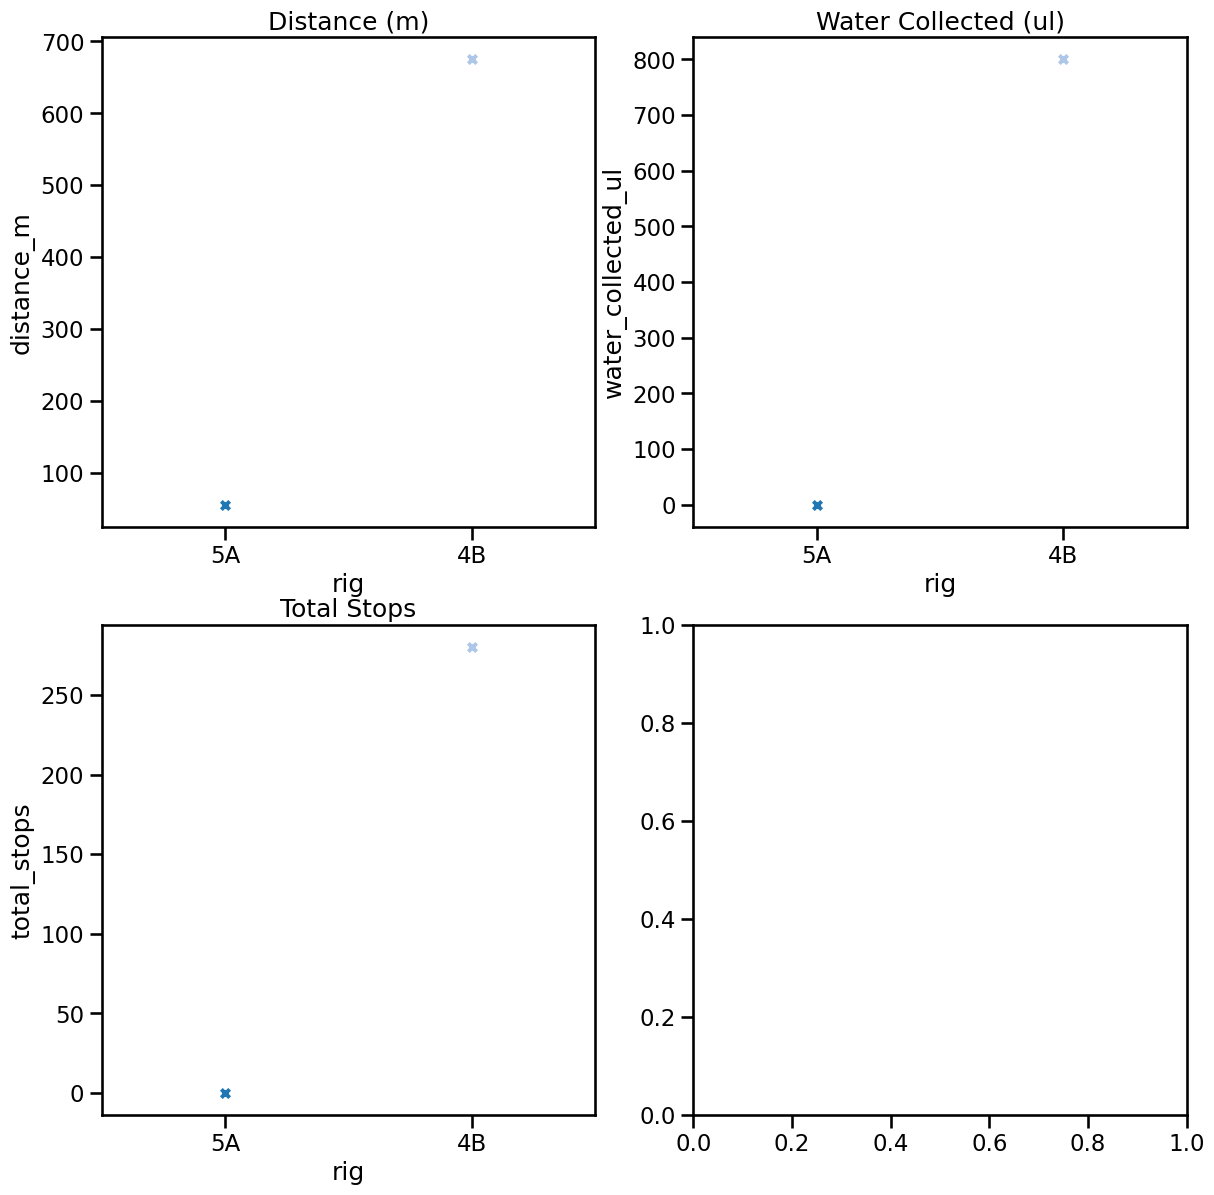

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming cum_session is already defined and contains the data

# Identify the latest date
latest_date = cum_session['session'].max()

fig = plt.figure(figsize=(14, 14))

# Plot with jitter using swarmplot and different alpha for the latest date
for i, (y_col, title) in enumerate(zip(['distance_m', 'water_collected_ul', 'total_stops', 'session_duration_min'],
                                       ['Distance (m)', 'Water Collected (ul)', 'Total Stops', 'Session Duration (min)'])):
    ax = fig.add_subplot(2, 2, i+1)
    sns.swarmplot(data=cum_session, x='rig', y=y_col, hue='mouse', palette='tab20', ax=ax, legend=(i == 3))
    sns.swarmplot(data=cum_session[cum_session['session'] == latest_date], x='rig', y=y_col, hue='mouse', marker='X', size=8,palette='tab20',  ax=ax, alpha=1, legend=False)
    ax.set_title(title)

# Create the legend outside the loop
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(1.4, 1), loc='lower right', borderaxespad=0., ncol=1)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=6, borderaxespad=0., ncol=1)
sns.despine()
plt.show()

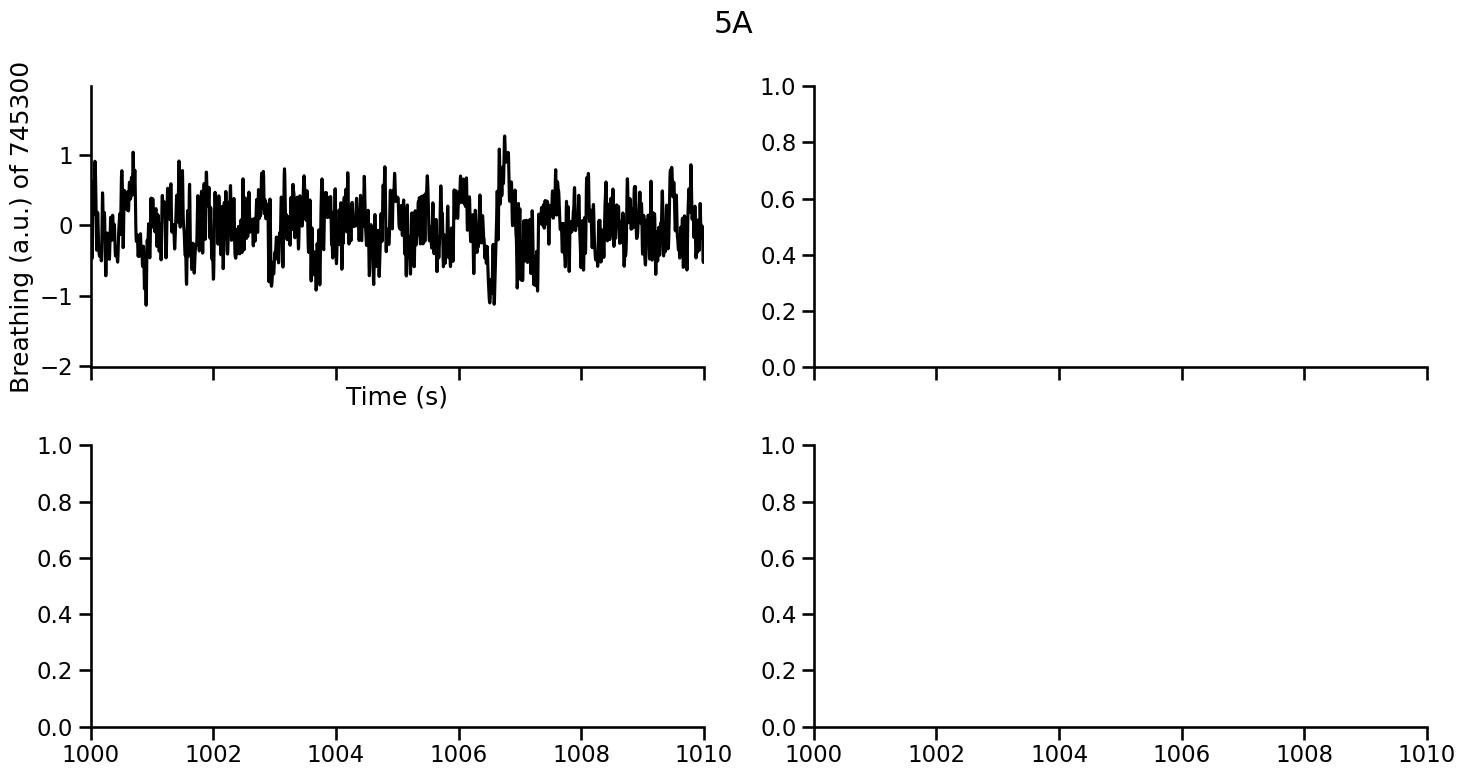

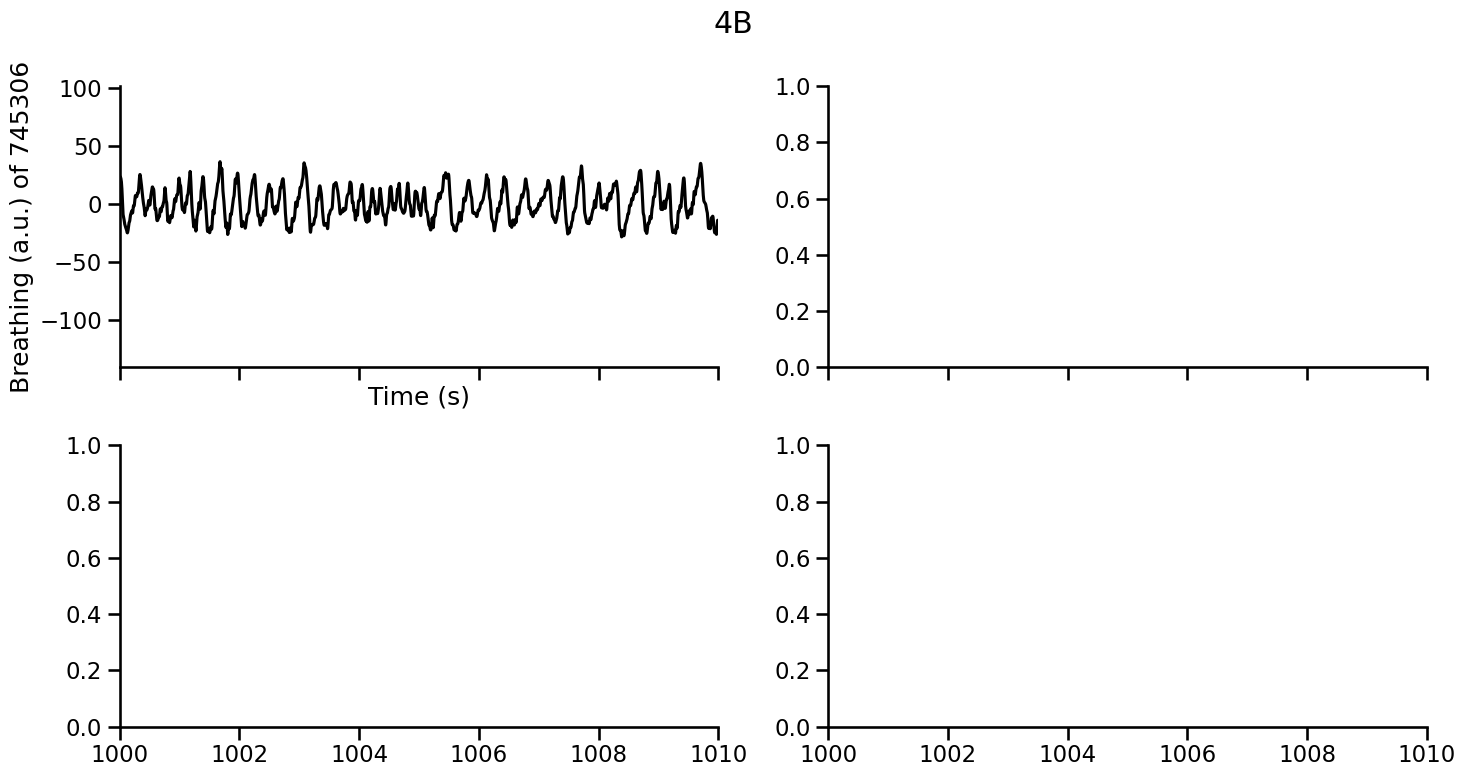

In [29]:
for rig_name in cum_breathing.rig.unique():
    plot_breathing = cum_breathing.loc[cum_breathing.rig == rig_name]
    fig, axs = plt.subplots(2,2, figsize=(15,8), sharex=True)
    plt.suptitle(f'{rig_name}')

    for mouse, ax in zip(plot_breathing.mouse.unique(), axs.flatten()):
        stream_data = plot_breathing.loc[plot_breathing.mouse == mouse]

        ax.plot(stream_data.Time, stream_data.breathing, color= 'black')

        # ax.set_ylim(-1500, 1500)
        ax.set_xlim(1000, 1010)
        ax.set_ylabel(f'Breathing (a.u.) of {mouse}')
        ax.set_xlabel('Time (s)')

    sns.despine()
    plt.tight_layout()
    plt.show()